In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')

db_url: str = os.getenv('DB_URL')

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lib import wrap_labels, adjust_pairplot_axes

In [3]:
sql = """
select 
    z.zip_code,
    z.neighborhood_name,
    z.borough_name,
    CASE WHEN z.is_harlem THEN 'Harlem' 
        WHEN z.borough_name = 'Manhattan' THEN 'Manhattan (Except Harlem)'
        ELSE z.borough_name END AS is_harlem,
    coalesce(total_admissions_3_2017, 0) AS "Estimated OTP Admissions (2017)",
    coalesce(total_admissions_3_2019, 0) AS "Estimated OTP Admissions (2019)",
    coalesce(otp_capacity, 0) AS "Reported OTP Capacity (2019)",
    coalesce(avg_daily_enrollment_2019, 0) AS "Reported Daily Avg OTP Enrollment (2019)",
    coalesce(patient_admissions_3_2019, 0) AS "Estimated OTP Patient Residents (2019)",
    coalesce(harlem_patient_admissions_3_2019, 0) As "Estimated OTP Patient Residents (Harlem Programs, 2019)",
    coalesce(opioid_burden_2019, 0) AS "Opioid Burden (2019)",
    z.population_total AS "Estimated Population (2020)"
from zip_codes z
    left join zip_code_otp_analysis za on z.zip_code = za.zip_code 
"""
zip_df = pd.read_sql(sql, con=db_url)


zip_df['Estimated OTP Patient Residents (Non-Harlem Programs, 2019)'] = \
    zip_df['Estimated OTP Patient Residents (2019)'] - zip_df["Estimated OTP Patient Residents (Harlem Programs, 2019)"]
zip_df['Estimated Fraction of OTP Admissions (2019)'] = zip_df["Estimated OTP Admissions (2019)"] \
    / zip_df["Estimated OTP Admissions (2019)"].sum()
zip_df['Estimated Fraction of OTP Patient Residents (2019)'] = zip_df["Estimated OTP Patient Residents (2019)"] \
    / zip_df["Estimated OTP Patient Residents (2019)"].sum()
zip_df['Estimated Fraction of Harlem OTP Patient Residents (2019)'] =  zip_df["Estimated OTP Patient Residents (Harlem Programs, 2019)"] / \
    zip_df["Estimated OTP Patient Residents (Harlem Programs, 2019)"].sum()
zip_df['Fraction of Opioid Burden (2019)'] =  zip_df["Opioid Burden (2019)"] / \
    zip_df["Opioid Burden (2019)"].sum()

for c in [
    'zip_code',
    'neighborhood_name',
    'borough_name',
    'is_harlem'
]:
    zip_df[c] = pd.Categorical(zip_df[c])

zip_df = zip_df.set_index('zip_code')

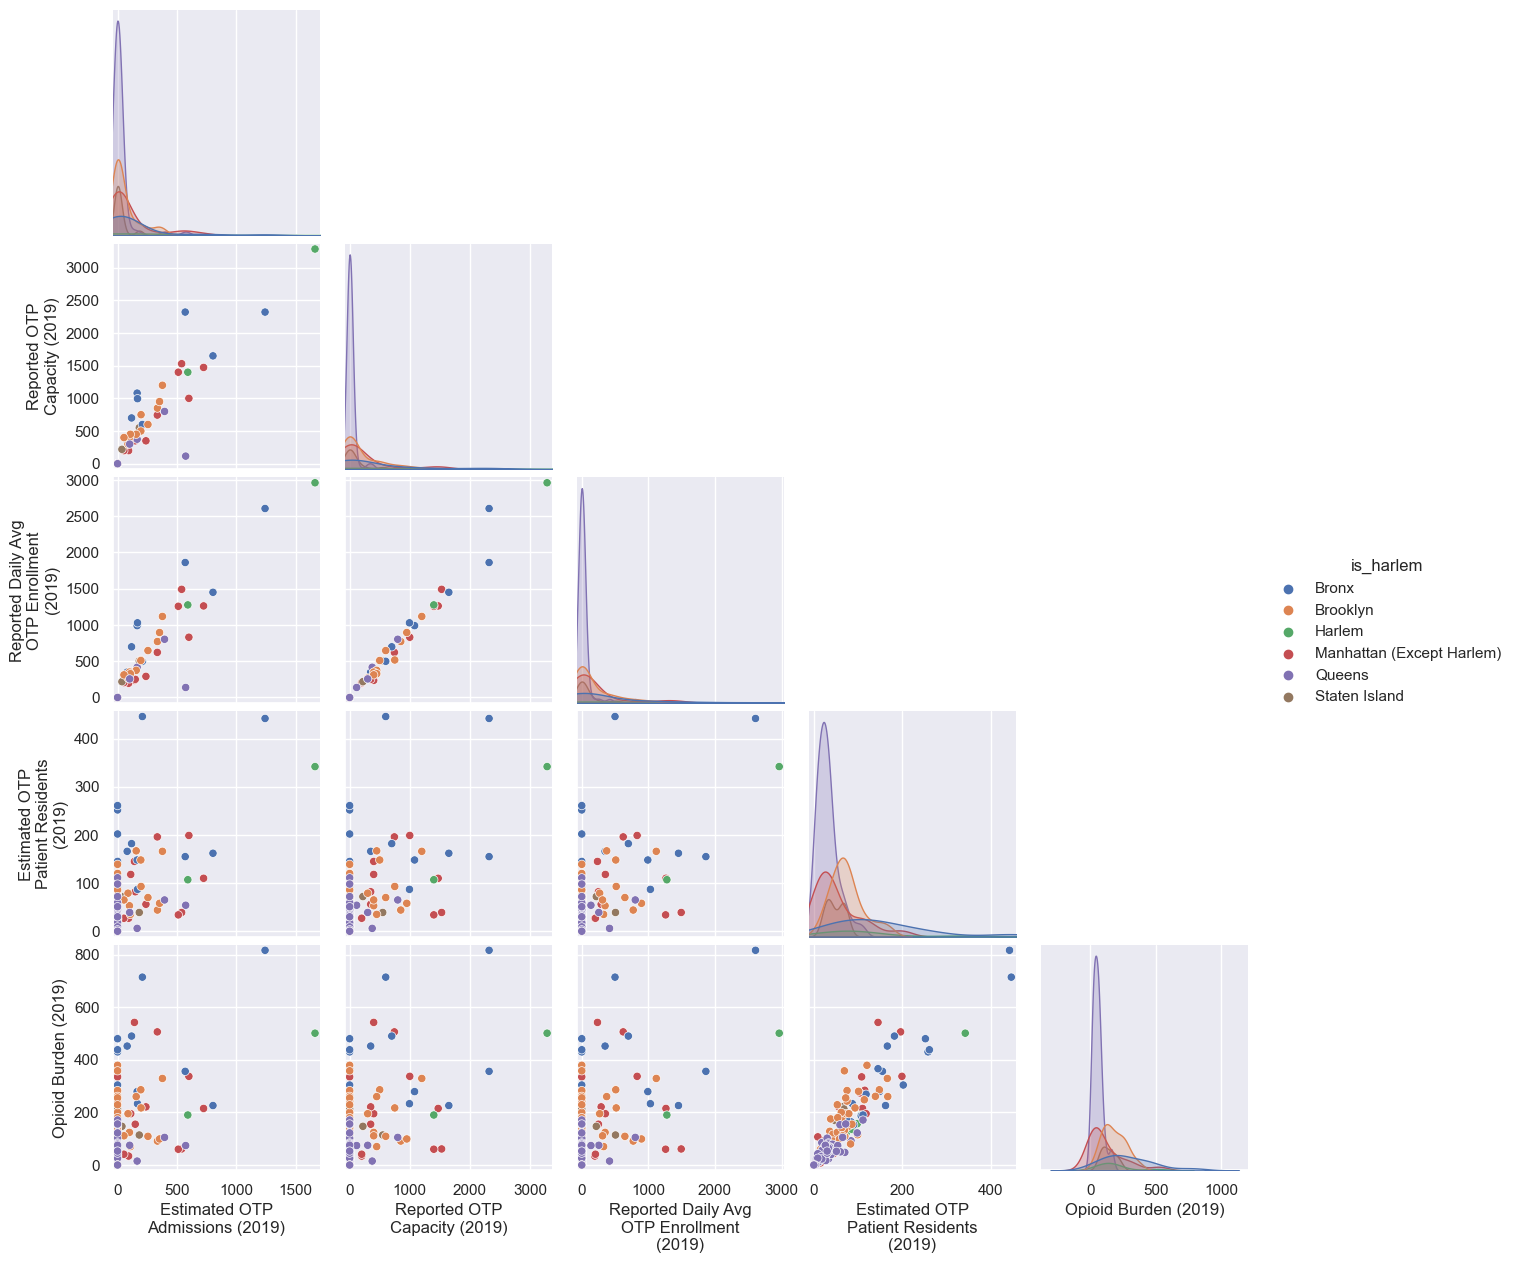

In [4]:
measures = [
    'Estimated OTP Admissions (2019)',
    'Reported OTP Capacity (2019)',
    'Reported Daily Avg OTP Enrollment (2019)',
    'Estimated OTP Patient Residents (2019)',
    'Opioid Burden (2019)'
]

p = seaborn.pairplot(
    zip_df[measures + ['is_harlem']], 
    hue='is_harlem',
    corner=True
)
adjust_pairplot_axes(zip_df, measures, p)

In [5]:
def plot_xy_interactive(df, x_col, y_col, color_col, identity_line=True):
    subset = df[[x_col, y_col]]
    subset_max_pct = subset.max().max()
    domain_max = subset_max_pct * 1.05
    scale = altair.Scale(domain=[0, domain_max])

    plot = (altair.Chart(df)
        .properties(height=500, width=500)
        .mark_circle(size=60)
        .encode(
            x=altair.X(x_col, scale=scale),
            y=altair.Y(y_col, scale=scale),
            color=color_col,
            tooltip=list(df.columns)
        )
        .interactive()
    )
    if identity_line:
        line = pd.DataFrame({
            x_col: [0, domain_max],
            y_col: [0, domain_max],
        })
        line_plot = altair.Chart(line)\
            .mark_line(color='gray', strokeDash=[2, 4])\
            .encode(x=x_col, y=y_col)
        return plot + line_plot
    else:
        return plot


In [6]:
plot_xy_interactive(
    zip_df,
    x_col = 'Estimated Fraction of OTP Patient Residents (2019)',
    y_col = 'Estimated Fraction of OTP Admissions (2019)',
    color_col='is_harlem'
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [7]:

(altair.Chart(zip_df)
    .properties(height=500, width=500)
    .mark_circle(size=60)
    .encode(
        x='Opioid Burden (2019)',
        y='Reported OTP Capacity (2019)', 
        color='is_harlem',
        tooltip=list(zip_df.columns)
    )
    .interactive()
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


,Estimated OTP Patient Residents (2019),Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019),Fraction of Opioid Burden (2019),Estimated Population (2020)
is_harlem,,,,,,
Bronx,0.322242,0.262426,0.313380,0.325445,0.298233,0.171389
Brooklyn,0.238108,0.173882,0.214344,0.208972,0.274137,0.308477
Harlem,0.069318,0.176305,0.146599,0.145385,0.054579,0.033305
Manhattan (Except Harlem),0.162638,0.273523,0.251799,0.240011,0.174353,0.158721
Queens,0.157959,0.096671,0.049784,0.055355,0.130723,0.271172
Staten Island,0.049736,0.017193,0.024094,0.024831,0.067974,0.056936


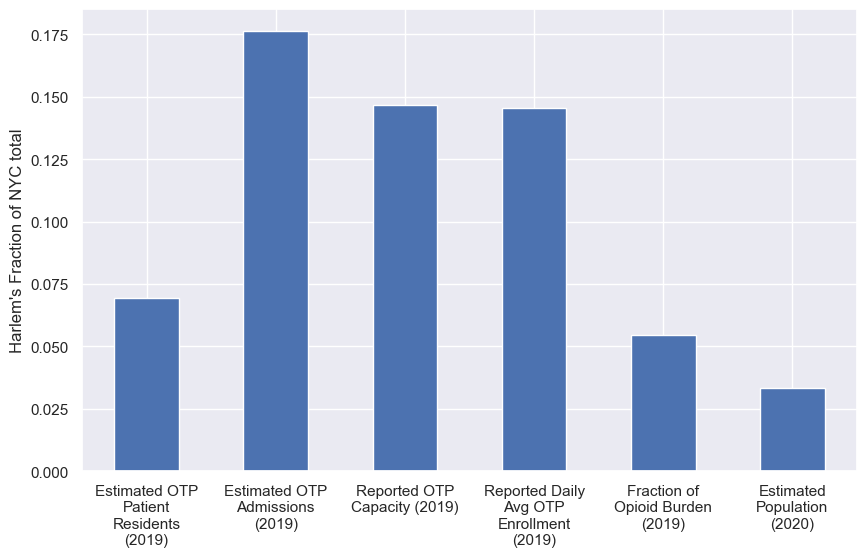

In [8]:
zip_program_metrics = (
    zip_df[[
        'Estimated OTP Patient Residents (2019)',
        'Estimated OTP Admissions (2019)',
        'Reported OTP Capacity (2019)',
        'Reported Daily Avg OTP Enrollment (2019)',
        'Fraction of Opioid Burden (2019)',
        "Estimated Population (2020)"
    ]]
    .groupby(zip_df['is_harlem'])
    .sum()
)

zip_program_metrics = zip_program_metrics / zip_program_metrics.sum()
ax = zip_program_metrics.loc['Harlem'].plot(
    kind='bar',
    ylabel="Harlem's Fraction of NYC total",
    figsize=(10, 6)
)
plt.xticks(rotation=0);
wrap_labels(ax, 15)
zip_program_metrics


,"Estimated OTP Patient Residents (Harlem Programs, 2019)"
is_harlem,
Bronx,0.277124
Manhattan (Except Harlem),0.233389
Harlem,0.210261
Queens,0.135408
Brooklyn,0.121110
Staten Island,0.022708


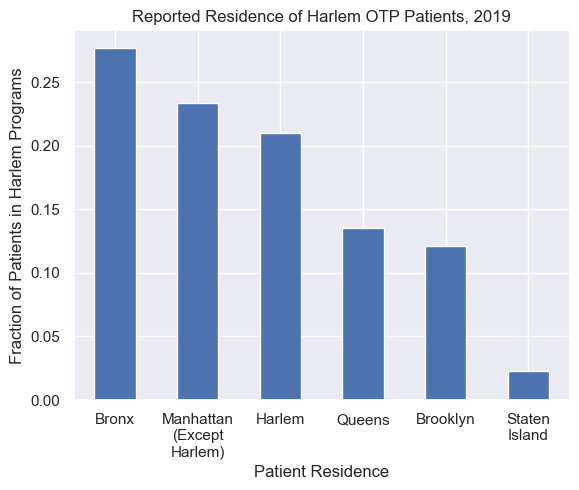

In [9]:
zip_patient_metrics = (
    zip_df[[
        "Estimated OTP Patient Residents (Harlem Programs, 2019)",
    ]]
    .groupby(zip_df['is_harlem'])
    .sum()
)
zip_patient_metrics = zip_patient_metrics / zip_patient_metrics.sum()
zip_patient_metrics = zip_patient_metrics.sort_values("Estimated OTP Patient Residents (Harlem Programs, 2019)", ascending=False)
ax = (zip_patient_metrics
    .plot(
        kind='bar',
        xlabel='Patient Residence',
        ylabel='Fraction of Patients in Harlem Programs',
        legend=False,
        title='Reported Residence of Harlem OTP Patients, 2019'
    )
)
plt.xticks(rotation=0)
wrap_labels(ax, 10)
zip_patient_metrics


,Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019),Estimated OTP Patient Residents (2019),Opioid Burden (2019),Estimated Population (2020)
is_harlem,,,,,,
Bronx,0.262426,0.313380,0.325445,0.322242,0.298233,0.171389
Brooklyn,0.173882,0.214344,0.208972,0.238108,0.274137,0.308477
Manhattan (Except Harlem),0.273523,0.251799,0.240011,0.162638,0.174353,0.158721
Queens,0.096671,0.049784,0.055355,0.157959,0.130723,0.271172
Harlem,0.176305,0.146599,0.145385,0.069318,0.054579,0.033305
Staten Island,0.017193,0.024094,0.024831,0.049736,0.067974,0.056936


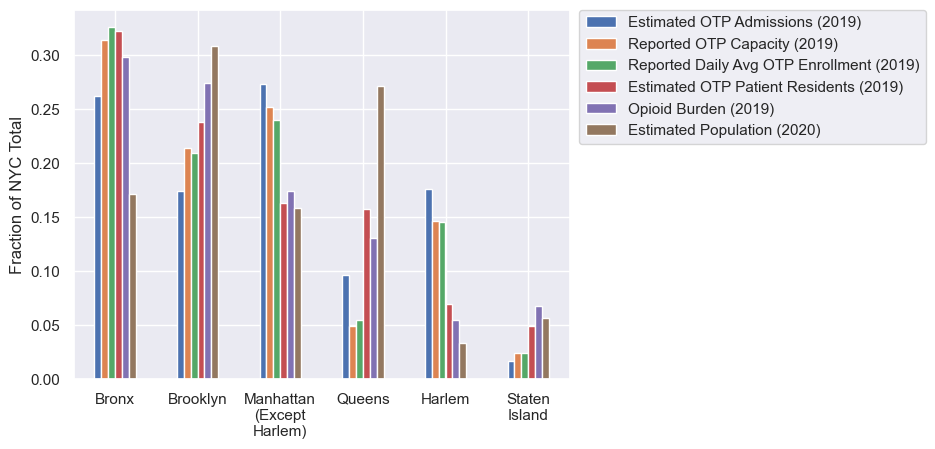

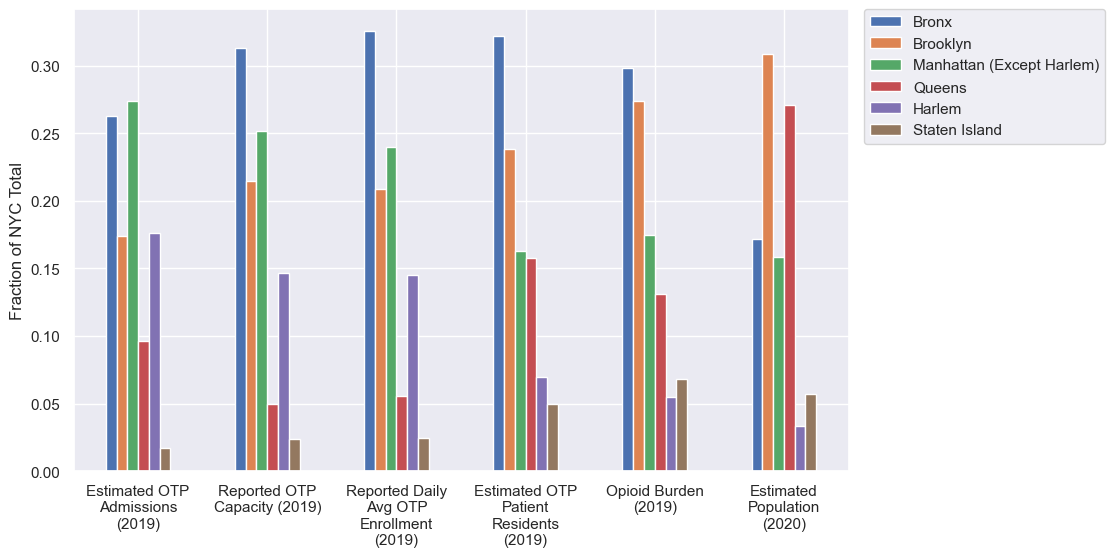

In [10]:
borough_program_metrics = zip_df[[
    'Estimated OTP Admissions (2019)',
    'Reported OTP Capacity (2019)',
    'Reported Daily Avg OTP Enrollment (2019)',
    'Estimated OTP Patient Residents (2019)',
    'Opioid Burden (2019)',
    "Estimated Population (2020)"
]].groupby(zip_df['is_harlem']).sum()
borough_program_metrics = borough_program_metrics / borough_program_metrics.sum()
borough_program_metrics = borough_program_metrics.sort_values('Estimated OTP Patient Residents (2019)', ascending=False)
ax = borough_program_metrics.plot(
    kind='bar', 
    xlabel='',
    ylabel='Fraction of NYC Total'
)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
wrap_labels(ax, 10)

# Sort of easier to see pivoted
ax2 = borough_program_metrics.T.plot(
    kind='bar', 
    ylabel='Fraction of NYC Total',
    figsize=(10,6)
)
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xticks(rotation=0)
wrap_labels(ax2, 15)

borough_program_metrics

In [ ]:
# Note: many Harlem OTP patients LEAVE Harlem for treatment; the actual ratio of residents:non is closer to 2:1 than 3:1.